# pybela-pytorch-xc-tutorial tutorial
In this workshop we'll be using jupyter notebooks and python to:
1. Record a dataset of potentiometer sensor values
2. Train a TCN to predict those values
3. Cross-compile and deploy the model to run in real-time in Bela

Connect your Bela to the laptop and run the cell below:

In [1]:
! ssh-keyscan $BBB_HOSTNAME >> ~/.ssh/known_hosts

usage: ssh-keyscan [-46cDHv] [-f file] [-p port] [-T timeout] [-t type]
		   [host | addrlist namelist]


Let's also import all the necessary python libraries:

In [2]:
import os
from pybela import Logger

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2 – potentiometers dataset capture

We are now ready to record a dataset with two potentiometers. Connect the second potentiometer to your Bela:

<p align="center">
  <img src="_fritzing/potentiometer_2.png" alt="potentiometer" width="300"/>
</p>

 We will be running the `dataset-capture` project. Now the first potentiometer controls the waveshape of an LFO and the second potentiometer, the volume of the sound.

Let's start by cross-compiling the code and copying it to Bela.

In [2]:
!cd code/bela-code/dataset-capture-2 && cmake -S . -B build -DPROJECT_NAME=dataset-capture -DCMAKE_TOOLCHAIN_FILE=/sysroot/root/Bela/Toolchain.cmake
!cd code/bela-code/dataset-capture-2 && cmake --build build -j

CMake Error at /usr/share/cmake-3.25/Modules/CMakeDetermineSystem.cmake:130 (message):
  Could not find toolchain file: /sysroot/root/Bela/Toolchain.cmake
Call Stack (most recent call first):
  CMakeLists.txt:7 (project)


CMake Error: CMake was unable to find a build program corresponding to "Unix Makefiles".  CMAKE_MAKE_PROGRAM is not set.  You probably need to select a different build tool.
CMake Error: CMAKE_C_COMPILER not set, after EnableLanguage
CMake Error: CMAKE_CXX_COMPILER not set, after EnableLanguage
-- Configuring incomplete, errors occurred!
No such file or directory
CMake Error: Generator: execution of make failed. Make command was:  -f Makefile -j && 


In [16]:
!rsync -rvL --timeout 10 code/bela-code/dataset-capture/build/dataset-capture root@$BBB_HOSTNAME:Bela/projects/dataset-capture/
!rsync -rvL --timeout 10 code/bela-code/dataset-capture/  --exclude="build" root@$BBB_HOSTNAME:/root/Bela/projects/dataset-capture/

sending incremental file list
dataset-capture

sent 698,636 bytes  received 6,875 bytes  470,340.67 bytes/sec
total size is 1,259,164  speedup is 1.78
sending incremental file list
CMakeLists.txt
Watcher.cpp
Watcher.h
render.cpp

sent 1,399 bytes  received 336 bytes  3,470.00 bytes/sec
total size is 26,516  speedup is 15.28


Now you can run the `dataset-capture` project on the Bela:

```bash
ssh root@bela.local
cd Bela/projects/dataset-capture && ./dataset-capture
```

Feel free to play around with the potentiometer and the piezo sensor. You can also edit the code in the IDE and re-run the project.

Once you're ready. You can record a dataset of potentiometer and piezo sensor values.

In [3]:
logger=Logger(ip=os.environ["BBB_HOSTNAME"])
logger.connect()

Running in Jupyter notebook. Enabling nest_asyncio.
Connection successful


1

In [6]:
logger.stop_logging()
logger.delete_all_bin_files_in_project()

Stopped logging variables ['wIn']...
File '/root/Bela/projects/dataset-capture/wIn.bin' has been removed from Bela.
All .bin files in /root/Bela/projects/dataset-capture have been removed.


You can time the length of your dataset using `asyncio.sleep(time_in_seconds)`. Note we are not using `time.sleep()` because it would block the Jupyter notebook.

In [7]:
file_paths = logger.start_logging(variables=["wIn"], transfer=False)
logger.wait(60*10)
logger.stop_logging()

Started logging variables ['wIn']... Run stop_logging() to stop logging.
Stopped logging variables ['wIn']...


In [8]:
file_paths

{'local_paths': {},
 'remote_paths': {'wIn': '/root/Bela/projects/dataset-capture/wIn.bin'}}

In [9]:
logger.copy_file_from_bela(file_paths["remote_paths"]["wIn"], "wIn_.bin")

Transferring /root/Bela/projects/dataset-capture/wIn.bin-->wIn_.bin... Done.


'wIn_.bin'

In [4]:
wIn_raw_data = logger.read_binary_file(file_path="wIn_.bin", timestamp_mode=logger.get_prop_of_var("wIn", "timestamp_mode"))

wIn_data = [data for _buffer in wIn_raw_data["buffers"] for data in _buffer["data"]]

# from IPython.display import Audio
# Audio(wIn_data, rate=44100)



We can now plot the data using matplotlib.

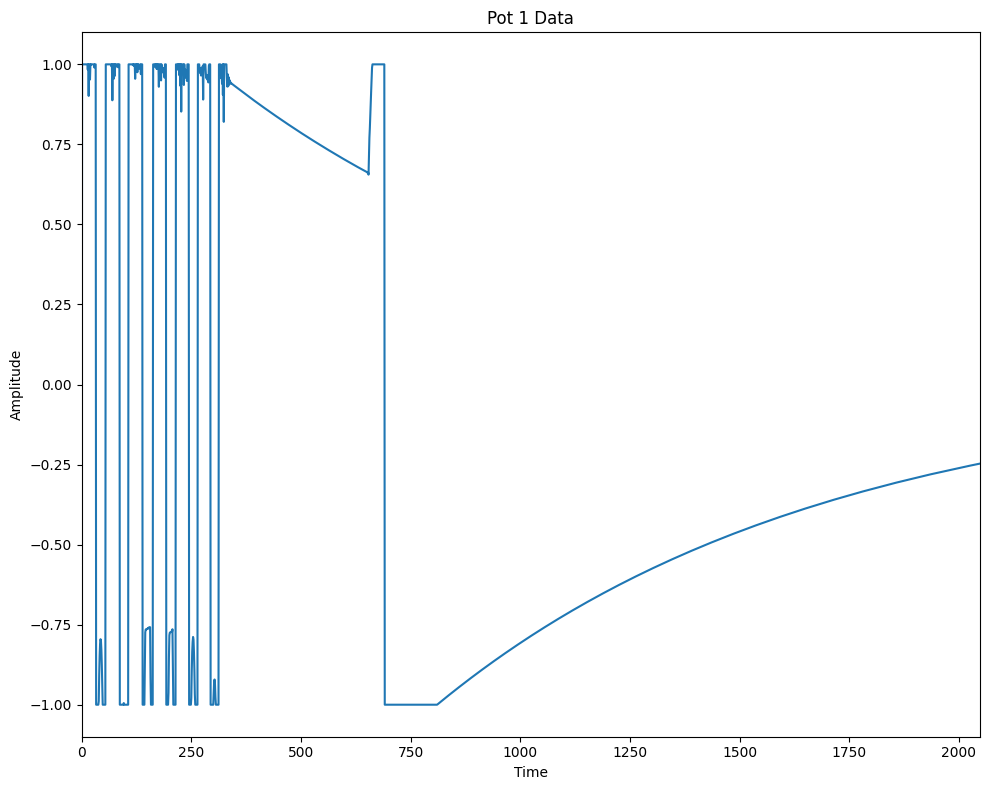

In [17]:

plt.figure(figsize=(10, 8))

plt.plot(np.arange(len(wIn_data)), wIn_data)
plt.title('Pot 1 Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.xlim(0, 2048)
 
plt.tight_layout()
plt.show()

In [16]:
2048/44100

0.046439909297052155

## 3 - train model
Now we are ready to train our model.
We can generate a pytorch compatible dataset using the `SensorDataset` class. This class divides the data you recorded previously in sequences of 512 values.

In [66]:
seq_len = 512
batch_size = 32
target_windows = 1

class AudioDataset(Dataset):
    def __init__(self, data, seq_len, target_windows):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        # make len divisible by seq_len
        _len = len(data)
        _len = _len - (_len % seq_len)
        data = data[:_len]
        
        sequences = torch.FloatTensor([data[i:i+seq_len] for i in range(0, len(data), seq_len)])

        self.inputs = sequences[:-target_windows]
        self.inputs = self.inputs.unsqueeze(2).to(self.device) # add feature dim
        outputs=[]
        for idx in range(1, len(sequences)-target_windows+1):
            tgt_seq =sequences[idx:target_windows+idx].flatten()
            outputs.append(tgt_seq)
        self.outputs = torch.stack(outputs).unsqueeze(2).to(self.device)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, i):
        return self.inputs[i], self.outputs[i]
    
dataset = AudioDataset(wIn_data, seq_len, target_windows)
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Using device: cuda


In [27]:
x,y = dataset.__getitem__(0)
dataset.outputs.shape, dataset.inputs.shape, x.shape, y.shape

(torch.Size([12920, 2048, 1]),
 torch.Size([12920, 2048, 1]),
 torch.Size([2048, 1]),
 torch.Size([2048, 1]))

Below we define a TCN. We will use an Adam optimiser with a learning rate of 0.001 and use the mean square error as loss.

In [71]:
class Chomp1d(nn.Module):
    """Layer that removes trailing values to ensure causality in the TCN."""
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    """A single temporal block in a TCN, with dilated causal convolutions and residual connections."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
        
import torch.nn.functional as F

class TemporalConvNetSimple(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.0, upsample_factor=3):
        super().__init__()
        self.upsample_factor = upsample_factor
        
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                                        dilation=dilation,
                                        padding=(kernel_size-1)*dilation, dropout=dropout))
        self.network = nn.Sequential(*layers)
        
        # Remove ConvTranspose
        self.output_layer = nn.Conv1d(num_channels[-1], num_inputs, 1)
        
    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, channels, seq)
        y = self.network(x)
        
        # Interpolate instead of transpose conv
        y = F.interpolate(y, scale_factor=self.upsample_factor, mode='linear', align_corners=False)
        
        y = self.output_layer(y)
        y = y.transpose(1, 2)
        return y


batch_size, sequence_len, feature_size = 32, 2048, 1
upsample_factor = target_windows  # Define the upsample factor
model = TemporalConvNet(num_inputs=feature_size, num_channels=[4, 4, 4], kernel_size=2, dropout=0.2, upsample_factor=upsample_factor)
model = model.to(device)
# Create a random tensor of shape [batch_size, sequence_len, feature_size]
x = torch.randn(batch_size, sequence_len, feature_size).to(device)
# Forward pass through the model
output = model(x)

print(output.shape)  # Output shape should be [batch_size, sequence_len*upsample_factor, feature_size]


torch.Size([32, 2048, 1])


In [79]:
import torch
import torch.nn as nn

class SimpleAudioRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1):
        super(SimpleAudioRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.lstm(x)  # out shape: (batch, seq_len, hidden_size)
        out = self.linear(out) # map hidden states back to audio samples
        return out

# Example usage:
model = SimpleAudioRNN(input_size=1, hidden_size=16).to(device)

# Create a batch of 1 with a window of 512 samples
x = torch.randn(1, 512, 1).to(device)

output = model(x)
print(output.shape)  # Should print: torch.Size([1, 512, 1])


torch.Size([1, 512, 1])


We can now train our model:

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')

epochs = 10

print("Running on device: {}".format(device))

epoch_losses = np.array([])
for epoch in range(1, epochs+1):

    print(">> Epoch: {} <<".format(epoch))

    # training loop
    batch_losses = np.array([])
    model.train()

    for batch_idx, (data, targets) in enumerate(tqdm(dataset_loader)):
        # (batch_size, seq_len, input_size)
        data = data.to(device=device, non_blocking=True)
        # (batch_size, seq_len, input_size)
        targets = targets.to(device=device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # lower memory footprint
        out = model(data)
        loss = torch.sqrt(criterion(out, targets))
        batch_losses = np.append(batch_losses, loss.item())
        loss.backward()
        optimizer.step()
    
    epoch_losses = np.append(epoch_losses, batch_losses.mean().round(4))

    print(f'Loss: {epoch_losses[-1]}')

Running on device: cuda
>> Epoch: 1 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:08<00:00, 192.77it/s]


Loss: 0.6903
>> Epoch: 2 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:08<00:00, 181.44it/s]


Loss: 0.6897
>> Epoch: 3 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:08<00:00, 180.62it/s]


Loss: 0.6864
>> Epoch: 4 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:09<00:00, 176.07it/s]


Loss: 0.6833
>> Epoch: 5 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:09<00:00, 177.63it/s]


Loss: 0.6865
>> Epoch: 6 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:09<00:00, 175.95it/s]


Loss: 0.6882
>> Epoch: 7 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:08<00:00, 185.15it/s]


Loss: 0.6892
>> Epoch: 8 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:04<00:00, 371.30it/s]


Loss: 0.6877
>> Epoch: 9 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:08<00:00, 184.51it/s]


Loss: 0.6887
>> Epoch: 10 <<


100%|██████████████████████████████████████████████████████████████| 1616/1616 [00:09<00:00, 175.10it/s]

Loss: 0.6881


We can plot the loss to see how the training went:

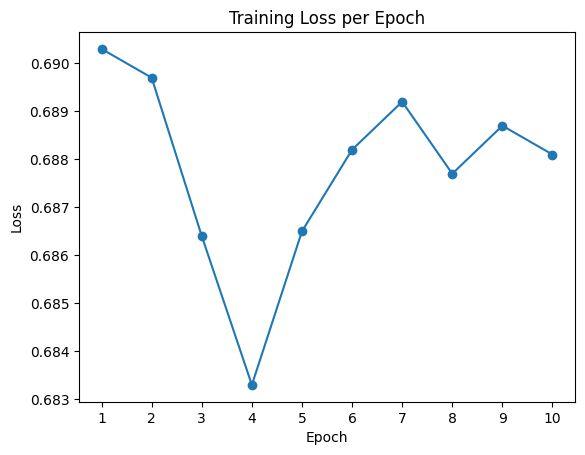

In [81]:
x_epochs = range(1, epochs + 1)

plt.scatter(x_epochs, epoch_losses, marker='o')
plt.plot(x_epochs, epoch_losses, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_epochs)  # Ensure x-axis has integer values for each epoch
plt.title('Training Loss per Epoch')
plt.show()

Let's make sure the model trained correctly by visualising some of the predictions.

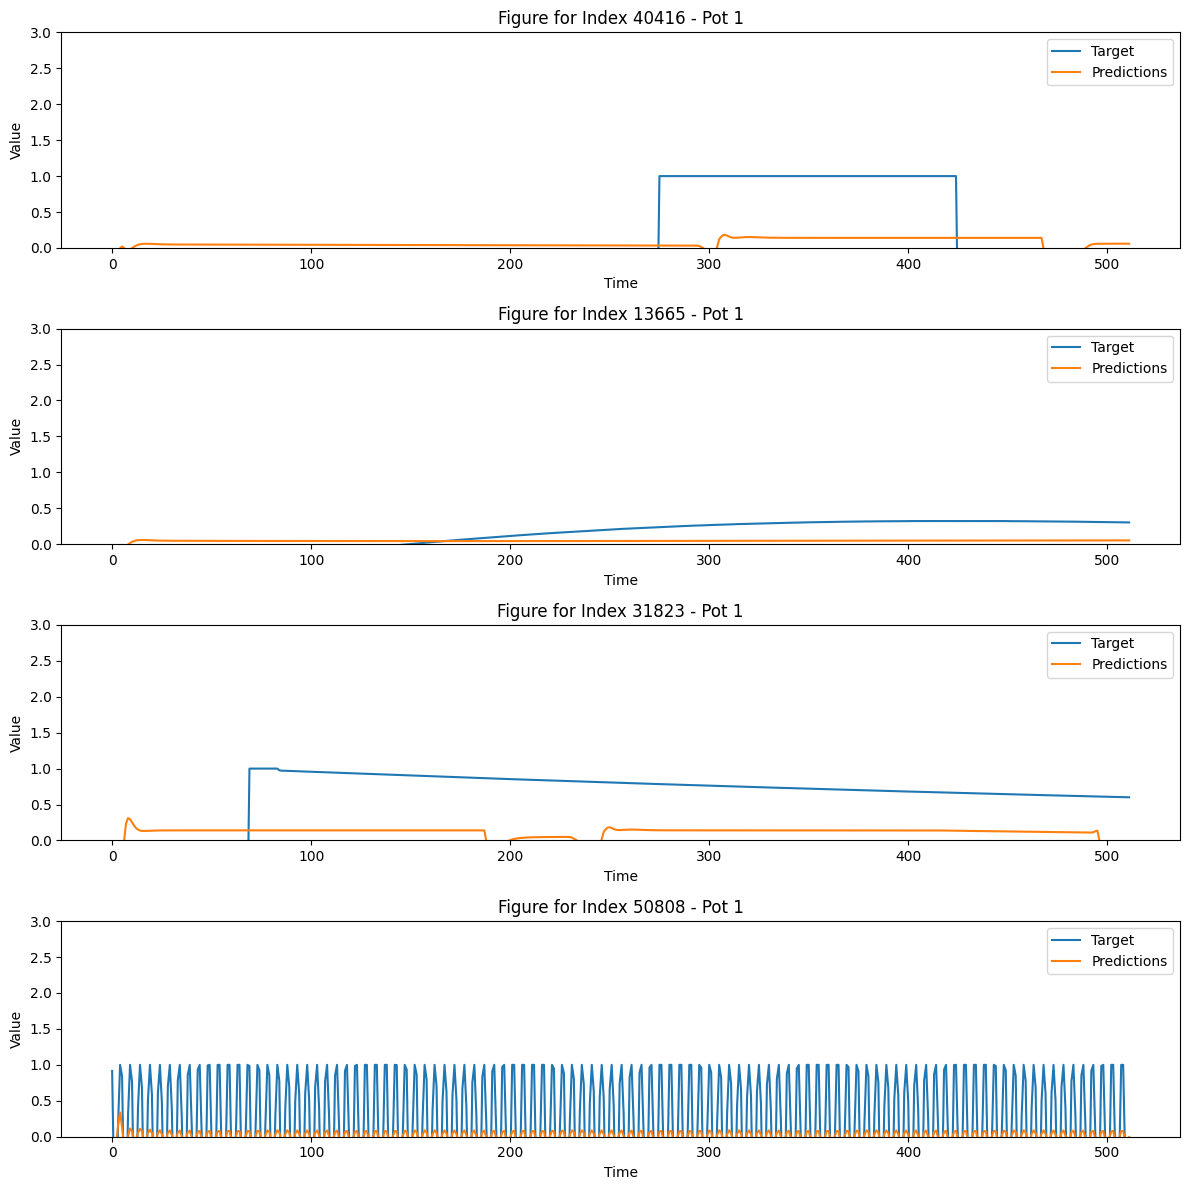

In [82]:
# Select random indexes for plotting
num_examples = 4
random_indexes = np.random.choice(len(dataset), size=num_examples, replace=False)

# Calculate the number of rows for the subplots
num_rows = num_examples

# Set up subplots
fig, axes = plt.subplots(num_rows, 1, figsize=(12, 3 * num_rows))

# Loop through random indexes and plot predictions
for idx, ax_row in zip(random_indexes, axes):
    input, target = dataset.__getitem__(idx)
    output = model(input.unsqueeze(0))
    
    # Plot for the first dimension in the first column
    ax_row.plot(target[:, 0].detach().cpu(), label='Target')
    ax_row.plot(output[0, :, 0].detach().cpu(), label='Predictions')
    ax_row.set_xlabel('Time')
    ax_row.set_ylabel('Value')
    ax_row.legend()
    ax_row.set_ylim(0, 3)
    ax_row.set_title(f'Figure for Index {idx} - Pot 1')
    


plt.tight_layout()
plt.show()

When you're ready, save the model so that we can export it into Bela.

In [88]:
model.to(device='cpu')
model.eval()
script = torch.jit.script(model)
path = "code/bela-code/inference/model.jit"
script.save(path)

In [89]:
torch.jit.load(path) # check model is properly saved

RecursiveScriptModule(
  original_name=SimpleAudioRNN
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (linear): RecursiveScriptModule(original_name=Linear)
)

## 4 - deploy and run

The cell below will cross-compile and deploy the project to Bela.

In [86]:
!cd code/bela-code/inference && cmake -S . -B build -DPROJECT_NAME=inference -DCMAKE_TOOLCHAIN_FILE=/sysroot/root/Bela/Toolchain.cmake
!cd code/bela-code/inference && cmake --build build -j

-- Enabling PyTorch frontend
-- Configuring done
-- Generating done
-- Build files have been written to: /root/code/code/bela-code/inference/build
[100%] Built target inference


In [90]:
!rsync -rvL --timeout 10 code/bela-code/inference/build/inference root@$BBB_HOSTNAME:Bela/projects/inference/
!rsync -rvL --timeout 10 code/bela-code/inference/  --exclude="build" root@$BBB_HOSTNAME:/root/Bela/projects/inference/

sending incremental file list

sent 47 bytes  received 16 bytes  126.00 bytes/sec
total size is 4,965,328  speedup is 78,814.73
sending incremental file list
CMakeLists.txt
Watcher.cpp
Watcher.h
main.cpp
model.jit
render.cpp
.ipynb_checkpoints/render-checkpoint.cpp

sent 5,879 bytes  received 710 bytes  13,178.00 bytes/sec
total size is 58,697  speedup is 8.91


Once deployed, you can run it from the Bela terminal (which you can access from your regular terminal typing `ssh root@bela.local`) by typing:
```bash
cd Bela/projects/inference
./inference -m model.jit
```